In [0]:
import numpy as np
import keras
import os
from sklearn.utils import shuffle
import time
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
import cv2
import glob
import collections
import matplotlib

np.random.seed(1337)
np.random.seed(42)

Using TensorFlow backend.


In [0]:
from zipfile import ZipFile
file_name = 'anime_data.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
def gen_erator(noise_shape):
  gen_input=keras.Input(shape=noise_shape)


  x=keras.layers.Conv2DTranspose(512, 4,strides=(1,1), padding='valid',data_format='channels_last')(gen_input)
  x=keras.layers.BatchNormalization(momentum=0.5)(x)
  x=keras.layers.LeakyReLU(0.2)(x)

  x=keras.layers.Conv2DTranspose(256, 4,strides=(2,2), padding='same',data_format='channels_last')(x)
  x=keras.layers.BatchNormalization(momentum=0.5)(x)
  x=keras.layers.LeakyReLU(0.2)(x)

  x=keras.layers.Conv2DTranspose(128, 4,strides=(2,2), padding='same',data_format='channels_last',kernel_initializer='glorot_uniform')(x)
  x=keras.layers.BatchNormalization(momentum=0.5)(x)
  x=keras.layers.LeakyReLU(0.2)(x)

  x=keras.layers.Conv2DTranspose(64, 4,strides=(2,2), padding='same',data_format='channels_last',kernel_initializer='glorot_uniform')(x)
  x=keras.layers.BatchNormalization(momentum=0.5)(x)
  x=keras.layers.LeakyReLU(0.2)(x)

  x=keras.layers.Conv2D(64, 3,strides=(1,1), padding='same',data_format='channels_last',kernel_initializer='glorot_uniform')(x)
  x=keras.layers.BatchNormalization(momentum=0.5)(x)
  x=keras.layers.LeakyReLU(0.2)(x)

  x=keras.layers.Conv2DTranspose(3, 4,strides=(2,2), padding='same',data_format='channels_last',kernel_initializer='glorot_uniform')(x)
  x=keras.layers.Activation('tanh')(x)

  gen_opt = keras.optimizers.Adam(learning_rate=0.00015, beta_1=0.5)
  gen_model = keras.Model(input = gen_input, output=x)
  gen_model.compile(loss='binary_crossentropy', optimizer = gen_opt,metrics=['accuracy'])
  gen_model.summary()
     
  return gen_model

In [0]:
def dis_criminator(img_shape=(64,64,3)):
  img_shape=image_shape

  dropout_prob =0.4
  kernel_init = 'glorot_uniform'
  dis_input = keras.Input(shape = img_shape)

  y = keras.layers.Conv2D(64, 4, strides=(2,2), padding = 'same', data_format='channels_last', kernel_initializer='glorot_uniform')(dis_input)
  y = keras.layers.LeakyReLU(0.2)(y)
  
  y = keras.layers.Conv2D(128, 4, strides=(2,2), padding = 'same', data_format='channels_last', kernel_initializer='glorot_uniform')(y)
  y = keras.layers.BatchNormalization(momentum=0.5)(y)
  y = keras.layers.LeakyReLU(0.2)(y)

  y = keras.layers.Conv2D(256, 4, strides=(2,2), padding = 'same', data_format='channels_last', kernel_initializer='glorot_uniform')(y)
  y = keras.layers.BatchNormalization(momentum=0.5)(y)
  y = keras.layers.LeakyReLU(0.2)(y)

  y = keras.layers.Conv2D(512, 4, strides=(2,2), padding = 'same', data_format='channels_last', kernel_initializer='glorot_uniform')(y)
  y = keras.layers.BatchNormalization(momentum=0.5)(y)
  y = keras.layers.LeakyReLU(0.2)(y)

  y = keras.layers.Flatten()(y)
  y = keras.layers.Dense(1)(y)
  y = keras.layers.Activation('sigmoid')(y)

  dis_opt = keras.optimizers.Adam(0.0002, beta_1=0.5)
  dis_model =keras.Model(input=dis_input, output = y)

  dis_model.compile(loss='binary_crossentropy', optimizer = dis_opt,metrics=['accuracy'])
  dis_model.summary()

  return dis_model


In [0]:
np.random.seed(1337)
def norm_img(img):
  img= (img/127.5)+1
  return img

def de_norm_img(img):
  img = (img+1)*127.5
  return img.astype(np.uint8)

In [0]:
def sample_dataset_format (batch_size, image_shape , data_dir=None , data=None):
  sample_dim = (batch_size,)+image_shape
  sample = np.empty(sample_dim, dtype=np.float32)
  all_data_dirlist = list(glob.glob(data_dir));
  sample_img_paths = np.random.choice(os.listdir(data_dir), batch_size)
  for index, img_file_name in enumerate( sample_img_paths):
    image = Image.open('/content/cropped/'+img_file_name)
    #cv2.imshow(index,image)
    print(image)
    image = image.resize(image_shape[:-1])
    image = image.convert('RGB')
    image = np.asarray(image)

    image = norm_img(image)

    sample[index,...] = image
  return sample

In [0]:
def gen_noise(batch_size, noise):
  return np.random.normal(0,1,size=(batch_size,)+noise_shape)

In [0]:
def generate_image(generator, save_dir):
  noise= gen_noise(batch-size, noise_shape)
  fake_data_X = generator.predict(noise)
  print('Displaying generated images')
  plt.figure(figsize=(4,4))
  gs1 = matplotlib.gridspec.GridSpec(4,4)
  gs1.update(wspace=0, hspace=0)
  rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
  for i in range(16):
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    rand_index = rand-indices[i]
    image = fake_data_X[rand_index,: ,:,:]
    fig = plt.imshow(de_norm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.savefig(save_dir+str(time.time())+'_Genimage.png',bbox_inches='tight', pad_inches=0)
  plt.show()
    

In [0]:
def save_img_batch(img_batch,img_save_dir):
  plt.figure(figsize=(4,4))
  gs1 = matplotlib.gridspec.GridSpec(4,4)
  gs1.update(wspace=0, hspace=0)
  rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
  for i in range(16):
    ax1=plt.subplot(4,4,i+1)
    ax1.set_aspect('equal')
    rand_index = rand_indices[i]
    image = img_batch[rand_index, :,:,:]
    fig = plt.imshow(de_norm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.savefig(img_save_dir,bbox_inches='tight', pad_inches=0)
  plt.show()

In [0]:
noise_shape = (1,1,100)
batch_size= 64
num_steps=10000
image_shape = None
img_save_dir='/content/'
save_model = True
image_shape =(64, 64, 3)
data_dir='/content/cropped/'
log_dir=img_save_dir
save_model_dir=img_save_dir

In [0]:
discriminator = dis_criminator(image_shape)
generator = gen_erator(noise_shape)
discriminator.trainable = False

opt = keras.optimizers.Adam(0.00015, beta_1=0.5)
gen_inp = keras.Input(shape=noise_shape)
Gan_inp = generator(gen_inp)
Gan_opt = discriminator(Gan_inp)
gan = keras.Model(input=gen_inp, output = Gan_opt)
gan.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
gan.summary()

avg_disc_fake_loss= collections.deque([0],maxlen=250)
avg_disc_real_loss= collections.deque([0],maxlen=250)
avg_Gan_loss= collections.deque([0],maxlen=250)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         5245

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 512)         819712    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 256)         0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  if __name__ == '__main__':


Begin step: 0
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F0F9E0CE6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=97x97 at 0x7F0F9E0CE6A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=82x82 at 0x7F0F9E0CE6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=92x92 at 0x7F0F9E0CE748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=102x102 at 0x7F0F9E0CE6A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=113x113 at 0x7F0F9E0CE6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=85x85 at 0x7F0F9E0CE748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=92x92 at 0x7F0F9E0CE6A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=88x88 at 0x7F0F9E0CE6D8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=90x90 at 0x7F0F9E0CE748>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=87x87 at 0x7F0F9E0CE6A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=110x110 at 0x7F0F9E0CE6D8>
<PIL.JpegImagePlugin

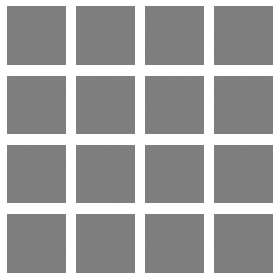

Disc: real loss: 0.768394 fake loss: 1.183859
GAN loss: 2.946800
Step 0 completed. Time took: 12 secs.
Begin step: 1
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=101x101 at 0x7F0F99929B70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=55x55 at 0x7F0F99929400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=91x91 at 0x7F0F99929A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=93x93 at 0x7F0F99929B70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=77x77 at 0x7F0F99929400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=115x115 at 0x7F0F99929A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x7F0F99929B70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=87x87 at 0x7F0F99929400>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=99x99 at 0x7F0F99929A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=78x78 at 0x7F0F99929B70>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=62x62 at 0x7F0F9992940

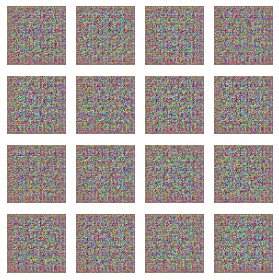

Disc: real loss: 0.870981 fake loss: 0.808694
GAN loss: 5.037374
Step 10 completed. Time took: 6 secs.
Begin step: 11
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=99x99 at 0x7F0F9D0A4F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=86x86 at 0x7F0F9D0A45C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=91x91 at 0x7F0F9D0A4F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=89x89 at 0x7F0F9D0A45C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=79x79 at 0x7F0F9D0A4F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=102x102 at 0x7F0F9D0A45C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=76x76 at 0x7F0F9D0A4F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=58x58 at 0x7F0F9D0A45C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=72x72 at 0x7F0F9D0A4F60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F0F9D0A45C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=113x113 at 0x7F0F9D0A4F60

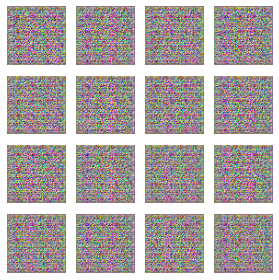

Disc: real loss: 0.387547 fake loss: 0.520815
GAN loss: 5.827429
Step 20 completed. Time took: 6 secs.
Begin step: 21
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=67x67 at 0x7F0F981F09E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=83x83 at 0x7F0F981F0668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=102x102 at 0x7F0F981F09E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=75x75 at 0x7F0F981F0668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F0F981F09E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=126x126 at 0x7F0F981F0668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=112x112 at 0x7F0F981F09E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=94x94 at 0x7F0F981F0668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=95x95 at 0x7F0F981F09E8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=78x78 at 0x7F0F981F0668>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F0F98

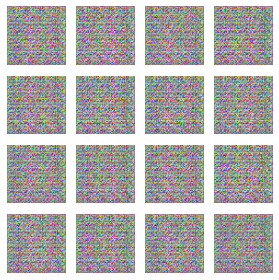

Disc: real loss: 0.673790 fake loss: 0.401447
GAN loss: 1.881437
Step 30 completed. Time took: 6 secs.
Begin step: 31
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=105x105 at 0x7F0F97D77C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=90x90 at 0x7F0F97D77908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=92x92 at 0x7F0F97D77C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=74x74 at 0x7F0F97D77908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=93x93 at 0x7F0F97D77C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=118x118 at 0x7F0F97D77908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=104x104 at 0x7F0F97D77C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=104x104 at 0x7F0F97D77908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=72x72 at 0x7F0F97D77C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=81x81 at 0x7F0F97D77908>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=92x92 at 0x7F0F97D7

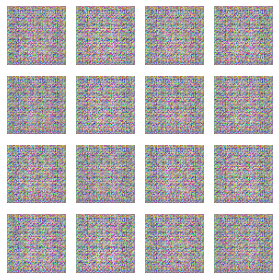

Disc: real loss: 0.393310 fake loss: 0.693660
GAN loss: 2.874504
Step 40 completed. Time took: 7 secs.
Begin step: 41
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=59x59 at 0x7F0F9D1A2C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=92x92 at 0x7F0F9D1A2128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=84x84 at 0x7F0F9D1A2C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=104x104 at 0x7F0F9D1A2128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=93x93 at 0x7F0F9D1A2C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=94x94 at 0x7F0F9D1A2128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x7F0F9D1A2C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=97x97 at 0x7F0F9D1A2128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=67x67 at 0x7F0F9D1A2C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=109x109 at 0x7F0F9D1A2128>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=97x97 at 0x7F0F9D1A2C

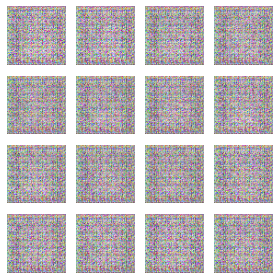

Disc: real loss: 0.376282 fake loss: 0.417186
GAN loss: 3.697062
Step 50 completed. Time took: 6 secs.
Begin step: 51
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=108x108 at 0x7F0F97E82CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=85x85 at 0x7F0F97E82DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=114x114 at 0x7F0F97E82CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x7F0F97E82DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=85x85 at 0x7F0F97E82CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=55x55 at 0x7F0F97E82DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=65x65 at 0x7F0F97E82CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=99x99 at 0x7F0F97E82DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=118x118 at 0x7F0F97E82CC0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F0F97E82DD8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=55x55 at 0x7F0F97E8

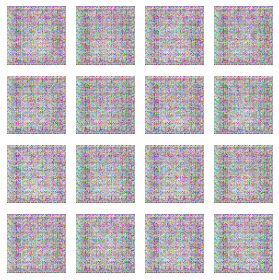

Disc: real loss: 0.486941 fake loss: 0.362676
GAN loss: 1.842685
Step 60 completed. Time took: 6 secs.
Begin step: 61
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=93x93 at 0x7F0F984717B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=77x77 at 0x7F0F98471AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=87x87 at 0x7F0F98471978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=52x52 at 0x7F0F984717B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=85x85 at 0x7F0F98471AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F0F98471978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F0F984717B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=78x78 at 0x7F0F98471AC8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=102x102 at 0x7F0F98471978>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=54x54 at 0x7F0F984717B8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=101x101 at 0x7F0F98471A

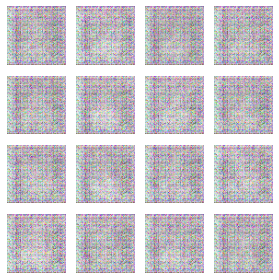

Disc: real loss: 0.503374 fake loss: 0.568892
GAN loss: 6.989492
Step 70 completed. Time took: 6 secs.
Begin step: 71
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=78x78 at 0x7F0F9799DC18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=90x90 at 0x7F0F9799DF28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=99x99 at 0x7F0F9799DEB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=82x82 at 0x7F0F9799DC18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F0F9799DF28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=103x103 at 0x7F0F9799DEB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=123x123 at 0x7F0F9799DC18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=68x68 at 0x7F0F9799DF28>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=58x58 at 0x7F0F9799DEB8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=62x62 at 0x7F0F9799DC18>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=101x101 at 0x7F0F9799

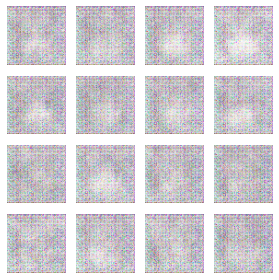

Disc: real loss: 0.601845 fake loss: 0.464303
GAN loss: 5.357966
Step 80 completed. Time took: 7 secs.
Begin step: 81
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=93x93 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=65x65 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=88x88 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=85x85 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x60 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=126x126 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=76x76 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=113x113 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=104x104 at 0x7F0F97820A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=69x69 at 0x7F0F9782

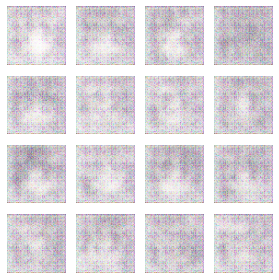

Disc: real loss: 0.371052 fake loss: 0.308742
GAN loss: 2.561435
Step 90 completed. Time took: 6 secs.
Begin step: 91
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=68x68 at 0x7F0F9D09F588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=42x42 at 0x7F0F97A926A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=73x73 at 0x7F0F9D09F588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=82x82 at 0x7F0F97A926A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=76x76 at 0x7F0F9D09F588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=120x120 at 0x7F0F97A926A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=108x108 at 0x7F0F9D09F588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=78x78 at 0x7F0F97A926A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=92x92 at 0x7F0F9D09F588>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=102x102 at 0x7F0F97A926A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=101x101 at 0x7F0F9D09

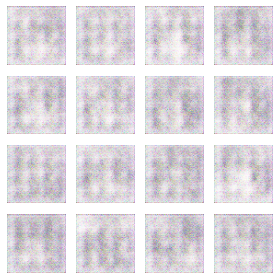

Disc: real loss: 0.575599 fake loss: 0.772171
GAN loss: 7.002903
Step 100 completed. Time took: 6 secs.
Begin step: 101
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=93x93 at 0x7F0F97F09240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=113x113 at 0x7F0F97F09390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=35x35 at 0x7F0F97F09240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=126x126 at 0x7F0F97F09390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=84x84 at 0x7F0F97F09240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=126x126 at 0x7F0F97F09390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=94x94 at 0x7F0F97F09240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=82x82 at 0x7F0F97F09390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=92x92 at 0x7F0F97F09240>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=65x65 at 0x7F0F97F09390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=94x94 at 0x7F0F97F0

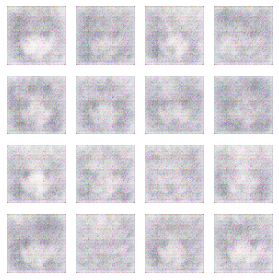

Disc: real loss: 0.521791 fake loss: 0.892792
GAN loss: 8.692141
Step 110 completed. Time took: 7 secs.
Begin step: 111
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=82x82 at 0x7F0F9D0525F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=95x95 at 0x7F0F9D052518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=89x89 at 0x7F0F9D052C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=87x87 at 0x7F0F9D0525F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=68x68 at 0x7F0F9D052518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=136x136 at 0x7F0F9D052C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=89x89 at 0x7F0F9D0525F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=102x102 at 0x7F0F9D052518>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=105x105 at 0x7F0F9D052C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=66x66 at 0x7F0F9D0525F8>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=104x104 at 0x7F0F9D

In [0]:
for step in range(num_steps):
  tot_step = step
  print('Begin step:',tot_step)
  step_begin_time = time.time()

  real_data_X = sample_dataset_format(batch_size, image_shape, data_dir =data_dir)
  noise = gen_noise(batch_size,noise_shape)

  fake_data_X = generator.predict(noise)
  if (tot_step % 10)==0:
    step_num = str(tot_step).zfill(4)
    save_img_batch(fake_data_X, img_save_dir+step_num+'_image.png')
  
  data_X = np.concatenate([real_data_X, fake_data_X])
  real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
  fake_data_Y = np.random.random_sample(batch_size)*0.2
  data_Y = np.concatenate((real_data_Y,fake_data_Y))
  
  discriminator.trainable=True
  generator.trainable = False

  dis_metrics_real = discriminator.train_on_batch(real_data_X,real_data_Y)
  dis_metrics_fake = discriminator.train_on_batch(fake_data_X,fake_data_Y)

  print('Disc: real loss: %f fake loss: %f' %(dis_metrics_real[0],dis_metrics_fake[0]))

  avg_disc_fake_loss.append(dis_metrics_fake[0])
  avg_disc_real_loss.append(dis_metrics_real[0])

  generator.trainable= True
  GAN_X = gen_noise(batch_size, noise_shape)
  GAN_Y = real_data_Y

  discriminator.trainable= False
  gan_metrics = gan.train_on_batch(GAN_X,GAN_Y)
  print('GAN loss: %f'% (gan_metrics[0]))

  end_time = time.time()
  diff_time = int(end_time-step_begin_time)
  print('Step %d completed. Time took: %s secs.'%(tot_step, diff_time))

  if ((tot_step+1)%500) == 0:
    print('__________________________________________________________________')
    print('Average Disc_fake loss: %f'%(np.mean(avg_disc_fake_loss)))
    print('Average Disc_real loss: %f'%(np.mean(avg_disc_real_loss)))
    print('Average GAN loss: %f' % (np.mean(avg_Gan_loss)))
    print('__________________________________________________________________')
    discriminator.trainable=True
    generator.trainable = True
    generator.save(save_model_dir +str(tot_step)+'_Generator_weights_and_arcc.hdf5')
    discriminator.save(save_model_dir+str(tot_step)+'_Discriminator_weights_and_arch.hdf5')


In [0]:
print(real_data_y)

# New Section